<a href="https://colab.research.google.com/github/DawnDJ/BIOS0032/blob/main/bios0032_w5_p_practical_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI & Wildlife Images

In this notebook, you'll explore how AI can be used for large-scale ecological research.
We'll use a real-world case study: a camera trap project conducted by a UCL team in Kenya's Maasai Mara ecosystem.

Here’s a brief overview of what you will cover:

* Camera Traps: What they are and how they're used in ecology.
* Image Annotation: The process of labelling camera trap images.
* MegaDetector: An AI tool for automatically detecting animals in photos.
* SpeciesNet: An AI tool for automatically identifying the species of those animals.
* Model Evaluation: How to measure the performance of these AI tools.

**Notes**

- If a line starts with the fountain pen symbol (🖌️), it asks you to implement a code part or answer a question.
- Lines starting with the light bulb symbol (💡) provide important information or tips and tricks.
- Lines starting with the checkmark symbol (✅) reveal the solutions to specific exercises.

# Setup

Before starting, you need to load the lab's dataset to this colab instance and download some utility scripts.

## Run the setup script

Run the cell below to complete the setup.

In [3]:
# @title "Setup Script"
%%bash

# Need to avoid using the system python
export UV_SYSTEM_PYTHON=false

# Download utility scripts
wget -q https://github.com/mbsantiago/AI-Intervene-Training-Material/raw/refs/heads/main/CameraTrapsAI/colab_utils.py
wget -q https://github.com/mbsantiago/AI-Intervene-Training-Material/raw/refs/heads/main/CameraTrapsAI/ct_notebook_utils.py

# Create virtual environment for megadetector
uv venv .mdvenv/

# Activate virtual environment
source .mdvenv/bin/activate

# Install dependencies
uv pip install "setuptools==81.0.0"
uv pip install megadetector
uv pip install speciesnet

# Download and unzip data
gdown https://drive.google.com/uc?id=1iLf6H9Ck87D-g43pVpmz0f_mk0U7dlbF
unzip data.zip

# Download speciesnet model
mkdir -p models/speciesnet
curl -L -o model.tar.gz https://www.kaggle.com/api/v1/models/google/speciesnet/pyTorch/v4.0.1a/1/download
tar -xvf model.tar.gz --directory models/speciesnet

Archive:  data.zip
   creating: data/
   creating: data/.ipynb_checkpoints/
  inflating: data/.ipynb_checkpoints/manual_labels-checkpoint.csv  
   creating: data/metadata/
   creating: data/metadata/.ipynb_checkpoints/
  inflating: data/metadata/.ipynb_checkpoints/cameras-checkpoint.csv  
  inflating: data/metadata/.ipynb_checkpoints/labels-checkpoint.csv  
  inflating: data/metadata/cameras.csv  
  inflating: data/metadata/covariates.csv  
  inflating: data/metadata/labels.csv  
  inflating: data/metadata/images.parquet  
  inflating: data/metadata/all_detections.parquet  
   creating: data/gis/
   creating: data/gis/StudyArea/
  inflating: data/gis/StudyArea/Study_area.sbn  
  inflating: data/gis/StudyArea/Study_area.prj  
  inflating: data/gis/StudyArea/Study_area.dbf  
  inflating: data/gis/StudyArea/Study_area.shp  
  inflating: data/gis/StudyArea/Study_area.shx  
 extracting: data/gis/StudyArea/Study_area.cpg  
  inflating: data/gis/StudyArea/Study_area.sbx  
   creating: data/gi

Using CPython 3.12.12 interpreter at: /usr/bin/python3
Creating virtual environment at: .mdvenv/
Activate with: source .mdvenv/bin/activate
Using Python 3.12.12 environment at: .mdvenv
Audited 1 package in 4ms
Using Python 3.12.12 environment at: .mdvenv
Resolved 112 packages in 613ms
Prepared 10 packages in 1m 08s
Installed 111 packages in 966ms
 + absl-py==2.4.0
 + albucore==0.0.24
 + albumentations==2.0.8
 + annotated-types==0.7.0
 + asttokens==3.0.1
 + certifi==2026.1.4
 + charset-normalizer==3.4.4
 + clipboard==0.0.4
 + contourpy==1.3.3
 + cuda-bindings==12.9.4
 + cuda-pathfinder==1.3.4
 + cycler==0.12.1
 + decorator==5.2.1
 + dill==0.4.1
 + executing==2.2.1
 + fastquadtree==2.1.1
 + filelock==3.21.2
 + fire==0.7.1
 + fonttools==4.61.1
 + fsspec==2026.2.0
 + gitdb==4.0.12
 + gitpython==3.1.46
 + grpcio==1.78.0
 + humanfriendly==10.0
 + idna==3.11
 + iniconfig==2.3.0
 + intel-cmplr-lib-ur==2024.2.1
 + intel-openmp==2024.2.1
 + ipython==9.10.0
 + ipython-pygments-lexers==1.1.1
 + je

# Introduction

## Camera traps

**Camera traps** are static cameras set up in the wild to monitor animal populations.
Typically, they are triggered by motion, capturing an image whenever an animal moves within the camera's field of view.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0b/Wildlife_camera_%2851121829491%29.jpg/960px-Wildlife_camera_%2851121829491%29.jpg" alt="camera trap" width="500"/>

The images from camera traps show which species are in an area and what they're doing.
This data reveals how often animals appear, their activity times, and their general behaviour.
Camera traps are also relatively easy to set up and are great for capturing a wide range of medium to large animals.

By combining this animal data with environmental information, ecologists can answer important questions.
For example, a key goal is to understand how wildlife reacts to human pressure.
By comparing animal communities in areas with low versus high human impact, it's possible to find thresholds, or tipping points, where the ecosystem changes significantly.
Finding these thresholds helps inform conservation decisions, like where to create a protected area or what land-use rules to set.
Placing cameras strategically along these areas of varying human impact provides the data needed to answer these kinds of questions.

After the cameras are collected, the biggest challenge is going through all the photos.
A huge number of these images are "false triggers" with no animals, set off by things like waving grass.
Even when an animal is in the photo, it can be hard to identify if the view is bad, it's too far away, or it's an unfamiliar species.
On top of that, a single project can produce hundreds of thousands or even millions of images.
Manually checking every photo is extremely slow and often impossible for large studies.

This is one of the key ways AI is changing ecological work.
It helps by automating the slow task of sorting photos, which in turn makes large-scale studies using camera traps possible.
In this notebook, you will work with an example dataset from the Biome Health Project, learning how to use AI to process and analyse the collected imagery.

## Biome Health Project

The dataset you'll use comes from the Biome Health Project.
A key goal of this project is to study how wildlife responds to different levels of human pressure.
By understanding this response in detail, the project aims to identify specific pressure thresholds that can be used to guide conservation actions.

<img src="https://static.wixstatic.com/media/d56724_6d6b60fecd174d24a714672dafcf00cf~mv2.png/v1/crop/x_8,y_0,w_829,h_588/fill/w_829,h_588,al_c,q_90,enc_avif,quality_auto/Gradient_3.png" alt="Curves of wildlife response to human pressure" width="500" />

This notebook focuses on data from the Greater Maasai Mara Ecosystem in Kenya, a savanna famous for its abundant wildlife.
Below you see consecutive frames captured by a camera trap in Kenya.
It shows a hyena entering the scene and checking out a buffalo!

<img src="https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/WildlifeImages/hyena.gif?raw=true" alt="drawing" width="500"/>

The study area contains a mix of zones with different management rules.
It includes the Mara Triangle, a highly protected part of the Maasai Mara National Reserve, alongside community-run conservancies.
In the National Reserve, protection is very strict and the area is actively patrolled.
In the community conservancies, Maasai landowners partner with tourism companies and follow specific rules for grazing their cattle.
This setup creates a clear gradient of human and livestock pressure, from highly protected land to areas with more grazing and human presence.

To monitor wildlife, a team from UCL and local conservancy staff placed camera traps across the landscape.
A systematic approach was used to ensure the entire area was sampled evenly.
Over 180 motion-activated cameras were set up across a huge 1,200 km² area in a 2x2 km grid pattern.
In the centre of each grid square, one camera was mounted on a tree or post about 50 cm off the ground.

### Explore the landscape

Let's start by getting a feel for the landscape where the data was collected.

Run the cell below to generate an interactive map of the study area.
Each point on the map marks the location of a camera trap.

Take a moment to explore the map.
Zoom in, zoom out, and pan around the region.
Use the layer selection tool on the top right to switch between different views, like satellite imagery, topography, and street maps.
To build a better mental picture, search online for images of the "Maasai Mara National Reserve".

*Note*: Feel free to skip the code for generating the map.
We'll explore this in more depth during the AI & Remote Sensing week.


In [4]:
# @title "Camera Trap Location Map"

from functools import partial

# To generate the map we will use folium for generating an interactive map
import folium

# Geopandas is another spatial library we are using to read spatial info.
import geopandas as gpd
import pandas as pd

# Read the information about where the cameras were placed
cameras = pd.read_csv("data/metadata/cameras.csv")

areas = {
    "Mara Triangle": {
        "path": "data/gis/Triangle/",
        "color": "green",
    },
    "Mara North Conservancy": {
        "path": "data/gis/MaraNorthConservancy/",
        "color": "blue",
    },
    "Motorogi Conservancy": {
        "path": "data/gis/MotorogiConservancy/",
        "color": "orange",
    },
    "Olare Orok Conservancy": {
        "path": "data/gis/OlareOrokConservancy/",
        "color": "orange",
    },
    "Naboisho Conservancy": {
        "path": "data/gis/NaboishoConservancy/",
        "color": "purple",
    },
}


def style_fn(feature, color):
    return {"fillColor": color, "color": color}


def get_regime(location_id):
    conservancy = location_id[:-2]
    return {
        "MT": "Mara Triangle",
        "MN": "Mara North Conservancy",
        "OMC": "Motorogi Conservancy",
        "NB": "Naboisho Conservancy",
    }[conservancy]


m = folium.Map(tiles=None)

folium.TileLayer("OpenTopoMap", overlay=False).add_to(m)
folium.TileLayer("Esri.WorldImagery", overlay=False).add_to(m)
folium.TileLayer("OpenStreetMap", overlay=False).add_to(m)

crs = "EPSG:4326"

m.fit_bounds(
    [
        [cameras.Latitude.min(), cameras.Longitude.min()],
        [cameras.Latitude.max(), cameras.Longitude.max()],
    ]
)

for _, row in cameras.iterrows():
    regime = get_regime(row["Location ID"])
    color = areas[regime]["color"]
    folium.Marker(
        location=[row.Latitude, row.Longitude],
        icon=folium.Icon(prefix="fa", icon="camera", color=color),
        popup=f"Location ID = {row['Location ID']}",
    ).add_to(m)

for name, data in areas.items():
    area = gpd.read_file(data["path"]).to_crs(crs)
    layer = folium.GeoJson(
        area.to_json(),
        style_function=partial(style_fn, color=data["color"]),
        name=name,
    )
    folium.Popup(name).add_to(layer)
    layer.add_to(m)

folium.LayerControl().add_to(m)

m

#### 🖌️*Build some initial hypothesis*

By looking at the map, consider these questions:

1. What major geographical features can you see?
   Look for things like rivers, hills, and potential changes in vegetation.
2. How might these features affect which animals live there?
   For example, would a leopard prefer a rocky outcrop or an open plain?

1.savanna,river,hills,farmlands.
2.open plain, it is favourable for a leopard to capture its prey.

### Data collection

The dataset for this lab comes from a single year, 2018.
For this year alone we collected a total of 2.4 million images.

At this stage, we have no idea what's in these photos.
They could be rare animals or just empty shots triggered by moving branches.
A good first step in any camera trap project is to analyse the metadata (the information about the images), like when and where they were taken.
This helps us understand the data collection process itself.

Let's visualise the entire 2018 data collection effort.
Run the cell below to generate a plot that gives an overview of when and where photos were taken.

Each column represents a single camera trap site.
Each row is a day of the year (from 1 to 365, but we focus on 260-340).
The color of each pixel shows the number of images taken at that site on that day.
White means no images were captured.

Notice that the site names tell you which area they belong to (e.g., the Mara Triangle or a specific conservancy).

/tmp/ipython-input-1084905652.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  images_metadata.groupby(


<Axes: xlabel='Site ID', ylabel='Day of Year'>

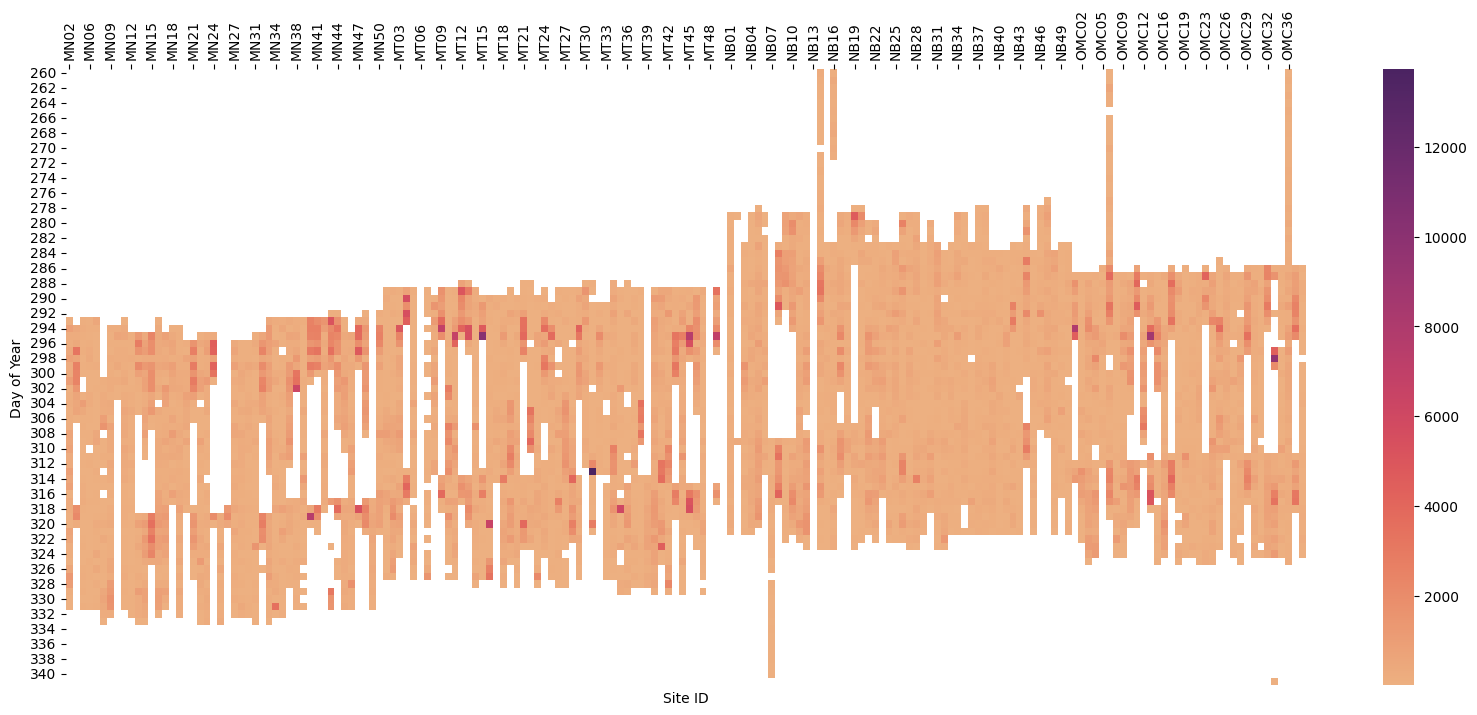

In [5]:
# @title "Number of Images per Day"
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

images_metadata = pd.read_parquet("data/metadata/images.parquet")

images_per_day = (
    images_metadata.groupby(
        [
            images_metadata.datetime.dt.day_of_year.rename("day_of_year"),
            images_metadata.site_id,
        ]
    )
    .size()
    .unstack()
)

images_per_day = images_per_day[images_per_day.index >= 260]

_, ax = plt.subplots(figsize=(20, 8))

ax.xaxis.tick_top()
sns.heatmap(
    images_per_day,
    ax=ax,
    mask=images_per_day == 0,
    cmap="flare",
)
ax.set(xlabel="Site ID", ylabel="Day of Year")

ax

#### 🖌️*Reflect on the collection effort*

Take a close look at the plot and think about these questions:

1. Why are there gaps and "noise" in the plot?
2. Do you see any broad patterns between the different areas?
   For example, did data collection start and stop at the same time everywhere?
3. Look at the color bar to see the range of values.
   Some sites have days with tens of thousands of images.
   Does a high image count for a site directly translate to high animal abundance?

1.Animal migrate to other areas?
2.The start and the end day of recording differ between the code of areas, same in one single area, different between areas, few areas are outliers.
3.No exactly, animal migration or waving weeds could be triggers as well.


# Data annotation

So, how do you find the animals in 2.4 million photos?
Before jumping into AI solutions, it's helpful to understand the traditional, manual approach.

The process of reviewing images to record information about them, like which species are present, is called **annotation** or **labelling**.

Before AI became common, all camera trap research relied on researchers, experts, or citizen scientists, manually annotating every single photo.
While this is incredibly slow, it has a major benefit: it gives the annotator a much closer familiarity with the data.
By looking through thousands of images, you gain an intuitive sense of what the data looks like, what to expect, and where potential issues might arise.
This hands-on experience is invaluable for correctly interpreting the final results of any analysis.

Manual annotation is also essential for building AI models.
The human-labelled images serve as the "ground truth" used to both train an AI model and test how well it performs.
We'll cover that in more detail later.
For now, it's time to get a feel for the annotation process yourself.

### Manual annotation

Your task is to review a small set of 10 images and detect any animals you see.

Run the cell below to launch the annotation tool.

Here are your instructions:

* Draw a box around every animal you can find.
  If there are multiple animals in one photo, make sure to box each one.
* Just detect, don't identify.
  For this exercise, your only task is to find the animals, not to name their species.
* Try to make your boxes as tight as possible around the animal, without including too much background.
* Remember, some images will be empty.
  If you don't see any animals, just move on to the next one.
* Be thorough!
  Do your best to find every animal, even if it's small, far away, or partially hidden.

When you've finished all 10 images, click the Submit button to save your work.

In [7]:
# @title "Annotator"
from pathlib import Path

from ct_notebook_utils import Annotator

# path for detection data
data_dir = Path.cwd() / "data"

image_dir = data_dir / "images"

selected_images = [
    Path("data/images/2018_NB01_001794.JPG"),
    Path("data/images/2018_NB40_002921.JPG"),
    Path("data/images/2018_MT22_020230.JPG"),
    Path("data/images/2018_OMC11_009862.JPG"),
    Path("data/images/2018_NB26_025049.JPG"),
    Path("data/images/2018_MN33_009632.JPG"),
    Path("data/images/2018_NB26_000679.JPG"),
    Path("data/images/2018_MT27_005639.JPG"),
    Path("data/images/2018_NB05_002216.JPG"),
    Path("data/images/2018_NB47_006890.JPG"),
]

# create a list with the numpy arrays that correspond to each of the
# images to annotate
annotator = Annotator(selected_images)

annotator.start()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

### Annotation costs

That short annotation task gives you a feel for the process.
But how does that effort scale up from 10 images to 2.4 million?

Run the cell below to see a report on your work from the last exercise.
It will show you how long it took to annotate the 10 images and how many animals you found.

In [8]:
# @title "Annotation Report"
# run this cell straight after your annotation
annotation_duration = annotator.duration
tagged_image_boxes = annotator.annotations

total_images = len(selected_images)

# convert time to minutes
print(f"The annotation of the {total_images} images took {annotation_duration}")

# given produced annotation list, we calculate total animals and the number
# of images with animals
num_animals = sum(x.shape[0] for x in tagged_image_boxes if x is not None)
num_non_empty_images = sum(x is not None for x in tagged_image_boxes)
annotation_speed = annotation_duration / float(len(selected_images))
print(
    f"In total, you found {num_animals} animals across {num_non_empty_images} images while "
    f"{total_images - num_non_empty_images} out of the {total_images} images were tagged as empty.\n"
    f"You tagged 1 image every {annotation_speed}"
)

The annotation of the 10 images took 0:02:53.956098
In total, you found 17 animals across 6 images while 4 out of the 10 images were tagged as empty.
You tagged 1 image every 0:00:17.395610


Now, let's see what it would take to annotate the entire 2018 dataset.
Run the next cell to launch an interactive tool that estimates the total time and cost.

Play around with the sliders in the tool to see how the numbers change.
You can control:

* Number of annotators: How many people are working on the project?
* Dataset percentage: Do you need to annotate all the images (100%), or just a smaller fraction?
* Hourly pay rate ($): How much would you pay an annotator per hour?


In [9]:
# @title "Extrapolating to the whole dataset"
import ipywidgets as widgets
import pandas as pd

images_metadata = pd.read_parquet("data/metadata/images.parquet")


@widgets.interact(
    num_annotators=(1, 20),
    dataset_percentage=(0.0, 1.0, 0.05),
    cost_per_hour=(6, 50),
)
def report_annotation_costs(num_annotators=1, dataset_percentage=1.0, cost_per_hour=17):
    total_images = len(images_metadata)

    num_images_to_annotate = int(total_images * dataset_percentage)

    total_duration = annotation_speed * (num_images_to_annotate / num_annotators)
    total_cost = total_duration.total_seconds() * cost_per_hour * num_annotators / 3600
    print(
        f"At the same speed it would take {num_annotators} person(s) a total "
        f"of {total_duration} to annotate {dataset_percentage:.1%} of the data ({num_images_to_annotate:,d} images).\n"
        f"This would cost {total_cost:,.2f}£ at an hourly rate of {cost_per_hour}£."
    )

interactive(children=(IntSlider(value=1, description='num_annotators', max=20, min=1), FloatSlider(value=1.0, …

#### 🖌️*Annotation costs of a MSc project*

Imagine you are analysing a dataset of 1 million images for your Master's thesis.
What percentage of the data can you afford to annotate in this timeframe?
Consider that this step is only one part of your project.

Aeound 60,000 images given months, 10hours everyday

# MegaDetector

Manually annotating millions of images is clearly not practical.
This is where a pre-trained AI model can save a huge amount of time.

For this notebook, we will use [**MegaDetector**](https://github.com/microsoft/CameraTraps/blob/main/megadetector.md), a model initially developed by Microsoft's AI for Earth program.
It was trained on millions of camera trap images from many different ecosystems, so it's generally robust and reliable.

**Note:** Like any AI, MegaDetector learned to detect animals by looking at a huge library of training examples.
It works best when your data is similar to what it was trained on. It might struggle with images from unique ecosystems or with different types of imagery (like from drones).
No AI is perfect, and it will make mistakes.
You can see some examples of known failure cases [here](https://github.com/agentmorris/MegaDetector/blob/main/megadetector-challenges.md).

Here are a few key things about it:

* MegaDetector's purpose is to find and draw boxes around three types of objects: animals, people, and vehicles.
  It doesn't identify the species of the animal, it just finds it.

* MegaDetector is "pretrained".
  This means it has already been trained on a large, general dataset.
  We can take this general, pre-trained model and apply it directly to our own images without any additional train.

* For every box it draws, MegaDetector provides a confidence score between 0 and 1.
  A score close to 1.0 means the model is very certain about its detection (e.g., "I'm 98% sure this is an animal").

* We can use these scores to automatically filter out empty images.
  By setting a confidence threshold, we can decide that any detection below a certain score isn't a "real" detection.
  Choosing this threshold is a trade-off: a lower threshold means you might find more animals but will also have to check more false positives.

* Modern versions of MegaDetector use the YOLOv5 architecture.
  YOLO (You Only Look Once) is a family of convolutional neural networks that has become an industry standard for real-time object detection.

## Running MegaDetector

It's time to run MegaDetector on the same 10 images you annotated manually.
This will give you a direct comparison between your work and the AI's predictions.

Using an AI model isn't always simple.
In general, you have to find the model's code repository (like on GitHub) and read the developers' notes to get it working.
Most models are built with deep learning frameworks (like [PyTorch](https://pytorch.org/) or [TensorFlow](https://www.tensorflow.org/)), and using them often requires some Python scripting.

Fortunately, because MegaDetector is so popular, there are many ways to use it:

* Desktop Apps: User-friendly tools like [Addax](https://addaxdatascience.com/addaxai/) provide a graphical interface.
* Cloud Services: Platforms like [Wildlife Insights](https://wildlifeinsights.org/) have integrated MegaDetector into their workflow.
* Code: You can always run it directly from a Python script, see its [official docs](https://megadetector.readthedocs.io/en/latest/).

### The command line

Here we'll use another common method: the command line.
This approach allows us to run the model by typing a "command" with a few parameters, telling it where the images are and how to process them.
It's a great way to run tools without needing a graphical interface or writing a full script.

**Note:** If you're new to the command line, it is a text-based way to give instructions to your computer.
You type commands into an application called a "terminal" to run programs or manage files.

Run the cell below.
It contains the command-line instruction to run MegaDetector on the example images.

In [13]:
%%bash

# activate the virtual environment
source .mdvenv/bin/activate

# Run the megadetector command
python -m megadetector.detection.run_detector_batch MDV5A \
  "data/images/" \
  "data/results/md_detections.json" \
  --output_relative_filenames \
  --threshold 0.2 \
  --quiet

Model v5a.0.1 already exists and is valid at /tmp/megadetector_models/md_v5a.0.1.pt
50 image files found in the input directory
PyTorch reports 0 available CUDA devices
GPU available: False
PyTorch reports 0 available CUDA devices
GPU available: False
Loading PT detector with compatibility mode classic
Loaded image size 1280 from model metadata
Using model stride: 64
PTDetector using device cpu
Loaded model in 5.67 seconds
Finished inference for 50 images in 9 minutes and 46.99 seconds (0.09 images per second)
Output file saved at data/results/md_detections.json
Done, thanks for MegaDetect'ing!


/content/.mdvenv/lib/python3.12/site-packages/yolov5/utils/general.py:34: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
Fusing layers... 
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs
100%|██████████| 50/50 [09:38<00:00, 11.58s/it]


#### 🖌️*Getting help with a CLI command*

As we've seen, running a command line tool often requires specific "arguments".
Luckily, most tools include a built-in manual to help you out.
Run the cell below to print the help message.
Read the descriptions and explain
1. What does the MDV5A in the previous command refer to?
2. What do the `threshold` and `batch_size` arguments control?


In [14]:
%%bash

# activate the virtual environment
source .mdvenv/bin/activate

# Run the command with the --help flag
python -m megadetector.detection.run_detector_batch --help

usage: run_detector_batch.py [-h] [--recursive] [--output_relative_filenames]
                             [--include_max_conf] [--verbose]
                             [--image_size IMAGE_SIZE] [--augment]
                             [--use_image_queue] [--preprocess_on_image_queue]
                             [--use_threads_for_queue] [--threshold THRESHOLD]
                             [--checkpoint_frequency CHECKPOINT_FREQUENCY]
                             [--checkpoint_path CHECKPOINT_PATH]
                             [--resume_from_checkpoint RESUME_FROM_CHECKPOINT]
                             [--allow_checkpoint_overwrite] [--ncores NCORES]
                             [--loader_workers LOADER_WORKERS]
                             [--class_mapping_filename CLASS_MAPPING_FILENAME]
                             [--include_image_size]
                             [--include_image_timestamp]
                             [--include_exif_tags INCLUDE_EXIF_TAGS]
                  

1. The 5th version of animal detecting model(v5a.0.1)
2. threshold: Confidence filter parameter, images with higher detection confidence than the threshold will be taken in as the final results.

  batch_size: The number of batches that dataset will be divided into before processing dataset.

### Inference speed

Once the process is finished, the cell output will show some statistics about how fast the model ran.

Find the line that looks like this:

    Finished inference for N images in M minutes and x seconds (y images per second)

Take note of the processing speed (the "images per second" value), as we'll use in the cell below.

**Note:** The first time you run the model, it takes a bit longer because the model files have to be downloaded and prepared for processing.
This is a one-time setup cost.
To get a more accurate measure of the model's true processing speed, it's a good idea to run the cell a second time and use that value.

Now that you have the processing speed, let's extrapolate.
How long would it take MegaDetector to process the entire 2.4 million image dataset?

Run the cell below to launch another interactive tool.
Input your "images per second" value from the previous step.
You can also use the slider to see how the total time changes if you only need to process a fraction of the dataset.

In [ ]:
# @title "MegaDetector Speed"
import datetime

import ipywidgets as widgets
import pandas as pd

images_metadata = pd.read_parquet("data/metadata/images.parquet")


@widgets.interact(
    images_per_sec=widgets.BoundedFloatText(
        value=0.28,
        min=0,
        max=10.0,
        step=0.01,
        description="Images per Sec:",
        disabled=False,
    ),
    dataset_percentage=(0.0, 1.0, 0.05),
)
def compute_megadetector_costs(
    images_per_sec=0.28,
    dataset_percentage=1,
):
    duration = datetime.timedelta(seconds=1 / images_per_sec)
    images_to_process = int(dataset_percentage * len(images_metadata))
    total_duration = duration * images_to_process
    print(
        f"MegaDetector would take {total_duration} to process {dataset_percentage:.0%} of the dataset (i.e. {images_to_process} images)"
    )

#### 🖌️*Inference cost of an MSc project*

Think back to the 1 million image MSc project scenario.
Based on the estimates we just calculated:

- Would you be able to process the whole dataset with MegaDetector in time for your deadline?
  How long would it take?
- Would it be possible to use Google Drive + Colab to store and process the images?
  Consider the total file size of 1 million images.

### Hardware choices

It's important to know that the model's processing speed heavily depends on the computer's hardware.

Most AI models run massively faster on a GPU compared to a standard CPU.
Not every computer has a compatible GPU, and they can be expensive.
However, using one can accelerate the process by orders of magnitude, turning a task that takes weeks into one that takes only a day.

**Note:** Curious to see the difference?
You can change the hardware for this Colab notebook.
Go to the "Runtime" menu at the top, select "Change runtime type", and choose a different "Hardware accelerator" (like GPU or CPU).

**Warning:** Changing the runtime will disconnect you and start a new session, so you'll have to run all the setup steps from the beginning of the notebook.

## MegaDetector outputs

When MegaDetector finished, it saved all its findings into a single output file located at: `data/results/md_detections.json`.

This is a `JSON` file, a common format for storing structured data.
While researchers often work with tables (like `CSV` files or Excel spreadsheets), `JSON` is widely used in software and on the web.
It's a text file, but the information is organised in a specific, nested way that can look a bit confusing at first.

### Raw JSON

Let's get a feel for what this raw data format looks like.

Use the file browser on the left to navigate to the `md_detections.json` file and double-click to open it.
It will appear in a new tab.

Don't worry about understanding every detail.
The goal is just to see how the information is structured.
When you're done, close the tab to come back to this notebook.

Since `JSON` is such a common format, it's worth getting familiar with it.
If you're curious to learn more, you can read about it [here](https://developer.mozilla.org/en-US/docs/Learn/JavaScript/Objects/JSON).

### Read the file with code

Now, let's use code to read that same JSON file and pull out a summary of what MegaDetector found.
Did you get the same number of animals?

Run the cell below.

In [ ]:
# @title "MegaDetector Report"
import json
from pathlib import Path

# Define the path to the output JSON file
data_dir = Path("data")
output_file_path = data_dir / "results" / "md_detections.json"

# Read the file as text
json_text = Path(output_file_path).read_text()

# "Parse" or convert the json text into a Python dictionary
md_output = json.loads(json_text)

selected_images = [
    "2018_NB01_001794.JPG",
    "2018_NB40_002921.JPG",
    "2018_MT22_020230.JPG",
    "2018_OMC11_009862.JPG",
    "2018_NB26_025049.JPG",
    "2018_MN33_009632.JPG",
    "2018_NB26_000679.JPG",
    "2018_MT27_005639.JPG",
    "2018_NB05_002216.JPG",
    "2018_NB47_006890.JPG",
]

# Create variables to keep track of empty images and total num of animals detected
total_animals = 0
empty_images = 0

# Read the info on each of the images
for file_info in md_output["images"]:

    # We will only extract info of the selected images
    if not Path(file_info["file"]).name in selected_images:
        continue

    # Count the number of detections in the image
    detections = len(file_info["detections"])

    # Add it to the total tally
    total_animals += detections

    if detections == 0:
        # If no detections add this image to the empty images tally
        empty_images += 1

# Compute the number of images with animals
total_images = len(selected_images)
non_empty_images = total_images - empty_images

# Print a report
print(
    f"In total, MegaDetector found {total_animals} animals across "
    f"{non_empty_images} images while {empty_images} out of the "
    f"{total_images} images were tagged as empty."
)

#### 🖌️*Are all detections animals?*

In the previous step, we counted every single detection.
However, MegaDetector identifies animals, humans, and vehicles.
Write code below to ensure we are counting only the animals.

*Hint:* Every detection has a category label.
Look inside `md_output['detection_categories']` to find out which label ID belongs to animals.

### Visualise the outputs

While the JSON file contains all the information, it's not easy to interpret on its own.
Visualizing the model's detections is always a good idea to make inspecting the results much easier.

First, run the cell below.
It will create a new folder with copies of the original images, but with MegaDetector's detections (the bounding boxes, labels, and confidence scores) drawn on top.

In [ ]:
%%bash

# activate the virtual environment
source .mdvenv/bin/activate

# run another megadetector command to generate visualisations
python -m megadetector.visualization.visualize_detector_output \
  --images_dir "data/images/" \
  "data/results/md_detections.json" \
  "data/results/md_viz/" \
  --output_image_width 1000

Now, run the next cell to display those annotated images in an interactive viewer right here in the notebook.

In [ ]:
# @title Visualise MegaDetector Outputs
from pathlib import Path

from ct_notebook_utils import image_tabs

data_dir = Path("data")

md_viz_dir = data_dir / "results" / "md_viz"

selected_images = [
    "2018_NB01_001794.JPG",
    "2018_NB40_002921.JPG",
    "2018_MT22_020230.JPG",
    "2018_OMC11_009862.JPG",
    "2018_NB26_025049.JPG",
    "2018_MN33_009632.JPG",
    "2018_NB26_000679.JPG",
    "2018_MT27_005639.JPG",
    "2018_NB05_002216.JPG",
    "2018_NB47_006890.JPG",
]

image_tabs(
    [
        path
        for path in md_viz_dir.glob("*.JPG")
        if path.name.replace("anno_", "") in selected_images
    ],
    width=1000,
)

Use the viewer to look through the 10 images.
Compare the AI's detections with the annotations you made earlier and think about the following questions:

1. How did the AI do?
   Did MegaDetector find the same animals that you did?
2. Did the AI miss anything?
   If you found an animal that MegaDetector missed, why do you think it failed?
3. Did the AI find anything you missed?
   Sometimes the model can spot things that are easy for a human eye to overlook.

#### 🖌️*Lowest confidence detection*

Can you find the least confident guess the model made?
Write code below to search through the detections in `md_output` and identify the minimum score.
Provide the filename in which it appears and the confidence value.

# Species classification

MegaDetector is a great first step for processing camera trap data, as it helps filter out all the empty images.
But if you want to identify which species are present, MegaDetector can't help.
The next step is typically to manually review all the non-empty images, or perhaps to build a custom species classifier.
However, a new tool called [**SpeciesNet**](https://github.com/google/cameratrapai) offers another powerful, pre-trained solution, similar to MegaDetector but for species identification.

Both models were trained on huge amounts of data.
SpeciesNet, for example, was trained on around 65 million images from all over the globe (see [this paper](http://doi.org/10.1049/cvi2.12318) for more details).
These images were collected, manually annotated by many different research teams, and then shared on platforms like Wildlife Insights.
The result is a model that synthesises a vast amount of expert knowledge to identify animals in photos.
Both models are also free and open-source, meaning you can inspect their code and use them however you like, as long as you attribute them correctly.

SpeciesNet is different from MegaDetector because it doesn't locate where an animal is in a photo.
Instead, it looks at the *whole image* and tries to identify the species shown.
Its current version can recognise 2,000 different classes of animals.
If it can't identify the exact species, it will attempt to name a higher taxonomic category (like genus or family).
Like MegaDetector, SpeciesNet also outputs a confidence score for each classification.

In most scenarios, the two models are best used together.
The ideal workflow is to run MegaDetector first to find and locate all the animals, then crop the image around each detection, and finally, run SpeciesNet on those smaller, cropped images to identify the species.

## Using SpeciesNet

### Run the SpeciesNet command

In [ ]:
%%bash

# activate the virtual environment
source .mdvenv/bin/activate

# this command runs megadetector and speciesnet in tandem
# note that we are specifying that the images are from Kenya
python -m megadetector.detection.run_md_and_speciesnet \
    --classification_model models/speciesnet \
    "data/images/" \
    "data/results/speciesnet_predictions.json" \
    --country KEN

### Visualise the outputs

In [ ]:
%%bash

# Activate the environment
source .mdvenv/bin/activate

# Run the visualise command
python -m megadetector.visualization.visualize_detector_output \
    --images_dir "data/images/" \
    "data/results/speciesnet_predictions.json" \
    "data/results/speciesnet_viz" \
    --output_image_width 1000

In [ ]:
# @title Visualise SpeciesNet Outputs
from pathlib import Path

from ct_notebook_utils import image_tabs

data_dir = Path("data")

speciesnet_viz_dir = data_dir / "results" / "speciesnet_viz"

image_tabs([path for path in speciesnet_viz_dir.glob("*.JPG")], show_max=50)

## SpeciesNet outputs

The output from SpeciesNet is saved in a JSON file, very similar to the one MegaDetector produced.

This format is useful because it's compatible with other tools.
For example, you could load these results into a graphical interface like [TimeLapse](https://timelapse.ucalgary.ca/) to review them visually.
For analysis, however, it's often easier to work with a simple table (like a CSV file).

Let's convert the JSON output into a more familiar tabular format.
The cell below extracts all the detection and classification information and saves it as a CSV file named `ai_outputs.csv`.
Run the cell, then use the file browser on the left to find and open the new CSV file to see what the final data looks like.

In [ ]:
# @title Turn Detections into Table
import json
from pathlib import Path

import pandas as pd

# Define the path to the speciesnet output file
data_dir = Path("data")
outputs_path = data_dir / "results" / "speciesnet_predictions.json"

# Read the JSON file as text
outputs_txt = outputs_path.read_text()

# Parse to python dictionary
speciesnet_results = json.loads(outputs_txt)

# Get the list of species categories (names) known to the model
classes = speciesnet_results["classification_categories"]

# Create an empty list to store our simplified detection data
species_df = []

# Loop through the results for each image
for file_predictions in speciesnet_results["images"]:

    # Loop through every detection found in that image
    for detection in file_predictions["detections"]:

        # Skip if the detection is not an animal
        if detection["category"] != "1":
            continue

        # Skip if the model didn't provide any species classification
        if "classifications" not in detection:
            continue

        # Extract bounding box coordinates
        minx, miny, width, height = detection["bbox"]

        # Get the top species prediction.
        # The model returns a list of guesses sorted by confidence;
        # we take the first one (index 0) as it is the most likely.
        class_num, class_score = detection["classifications"][0]

        # Map the class ID to the actual species name
        class_name = classes[class_num]

        # Skip if speciesnet thinks the "animal" detected by megadetector
        # is actually just blank background
        if class_name == "blank":
            continue

        # Append the relevant details to our list
        species_df.append(
            {
                "filepath": file_predictions["file"],
                "detection_score": detection["conf"],
                "class": class_name,
                "class_score": class_score,
                "minx": minx,
                "miny": miny,
                "width": width,
                "height": height,
            }
        )

# Convert the list into a pandas DataFrame
species_df = pd.DataFrame(species_df)

# Save the results to a CSV file
species_df.to_csv("ai_outputs.csv", index=False)
print("CSV saved")

#### 🖌️*Most common species*

Use the `species_df` dataframe to answer these two questions:

1. Which species (or class) was detected most frequently?
2. Is there a noticeable difference in the average confidence scores between species?

# Evaluating AI outputs

After running the AI models, we have a neat table of species detections.
But are they correct?
As you've probably noticed from the examples, the model's outputs aren't always accurate.
Even models trained on millions of images will make mistakes, especially if your data looks very different from their training data.

It is **critical** to get a quantitative measure of how well a model performs on your specific data.
Without this step, you risk basing your research on "model hallucinations" rather than real ecological patterns.
A good starting point is to read the performance reports from the model's creators, like the [accompanying paper](https://ietresearch.onlinelibrary.wiley.com/doi/10.1049/cvi2.12318) for SpeciesNet.
However, it is **strongly recommended** that you always perform your own independent evaluation on your own dataset.

Evaluating a model means comparing its predictions to a set of correct or *"ground truth"* answers.
To create dataset a dataset for testing the model you need to manually annotate a subset of your own images.
These annotations represent what you want the model to output.
By comparing the model's predictions to this ground truth, you can calculate a suite of performance metrics that measure how well the model is doing its job. This is why manual annotation remains a vital step in any AI-assisted study.

## Designing an evaluation dataset

How should you choose which images to manually annotate?
The way you select your sample can significantly impact your understanding of the model's performance.

#### 🖌️*Comparing two common sampling strategies*

Consider the pros and cons of these two common methods for selecting images to annotate for your ground truth:

* Method A: Random Image Sample

    Select a completely random sample of 1,000-2,000 images from the entire dataset and manually annotate everything in them.

* Method B: Species-Stratified Sample

    For each species you care about, select 20-30 random images that the AI has already labelled as that species, and then manually check if the AI was correct.

Think about what each method would allow you to measure.
For example:

- Which method is better for evaluating how well the model filters out empty images?
- What are the potential biases of Method B?
- What are the risks of Method A?

#### 🖌️*What else needs consideration?*

A random sample, while seemingly unbiased, can easily miss or underrepresent important conditions in your data.
For example, even if 30% of your images were taken at night, a small random sample might happen to include very few of them.
If the model performs poorly in the dark, your evaluation would fail to represent this weakness, giving you a misleadingly optimistic view of its overall performance.

Beyond just day vs. night, what other factors should you consider to ensure your evaluation set is representative and tests the model under different conditions?
List a few examples of how you might stratify your sample to get a more complete picture of the model's performance.

## Measuring model performance

Now, let's compare the AI's predictions to a "ground truth" dataset of annotations already prepared by the UCL team.

There are many ways to measure performance, and the "best" method depends on your research question.
The AI pipeline above gives us a lot of detail: it detects multiple animals, provides their exact locations with bounding boxes, and identifies their species.
While this level of detail is useful for some studies, many ecological questions only require knowing that a certain species was present at a site.
For analyses like occupancy modeling, it doesn't matter how many individuals were in the photo or exactly where they were.

For this exercise, let's assume that's our goal: we just want to know if the AI can correctly tell us which species were present in each image, matching the answers provided by human experts.

### Species labels

An important and surprisingly tricky step is to make sure we are comparing apples to apples.
This means ensuring that the species labels from our ground truth match the labels used by the AI model.

Because the manual annotations and the SpeciesNet model were created independently, their labels don't perfectly align.
Run the cell below to see a comparison of the two sets of labels.

In [ ]:
# @title Label Comparison
from itertools import zip_longest

import pandas as pd

annotations = pd.read_csv("data/metadata/labels.csv")

ann_labels = annotations.label.sort_values().unique()
pred_labels = species_df["class"].sort_values().unique()

print(f"{'Annotation Labels':^20} | {'SpeciesNet Labels':^20} ")
print(f"{'-' * 20} | {'-' * 20} ")
for ann_lab, pred_lab in zip_longest(ann_labels, pred_labels, fillvalue=""):
    print(f"{ann_lab:^20} | {pred_lab:^20}")

#### 🖌️*Mapping species labels*

Take a look at the two lists and think about the following questions:

* How would you match these two different sets of labels to allow for a fair comparison?
* If you were starting a new camera trap project today, how could you plan your annotation process to avoid this problem from the start?
  is it always possible?

### Understanding different types of errors

Let's focus our analysis on just one species: the impala.
For this exercise, we'll keep it simple and only count a prediction as correct if SpeciesNet gives the specific "impala" label, ignoring higher-level classifications like "bovidae family".

Our AI pipeline gives us two confidence scores for each detection, but for now, we'll just focus on the final species classification score from SpeciesNet.

Run the cell below.
It will go through each image in our ground truth set and calculate two things:
1. Does the image actually contain an impala (based on the manual labels)?
2. What was the AI's highest confidence score for "impala" in that image?
   (This will be 0 if the AI found no impalas).

In [ ]:
# @title Get Per Image Info
gt_classes = ["impala"]
pred_classes = ["impala"]


def get_pred_score(group):
    preds = group[group["class"].isin(pred_classes)]

    if len(preds) == 0:
        return 0

    return preds["class_score"].max()


comparison = (
    annotations.groupby("filename")
    .label.apply(lambda group: (group.isin(gt_classes)).any())
    .rename("ground_truth")
    .to_frame()
    .join(
        species_df.groupby("filepath")
        .apply(get_pred_score, include_groups=False)
        .rename("score")
    )
    .fillna(0)
    .reset_index()
)

comparison

Now we can use a confidence threshold to make a decision.
If an image's score is above the threshold, we'll say the AI predicted "impala".
If the score is below, we'll say it did not.

By comparing the AI's prediction to the ground truth for each image, we get one of four possible outcomes:

* True Positive (TP): The image has an impala, and the AI correctly predicted it.
* False Negative (FN): The image has an impala, but the AI missed it.
* False Positive (FP): The image does not have an impala, but the AI said it did.
* True Negative (TN): The image does not have an impala, and the AI correctly said it didn't.

Using these four outcomes, we can calculate two standard performance metrics:

* **Precision**: Of all the times the AI predicted "impala", what fraction was it correct?

  $$ Precision = \frac{TP}{TP + FP} $$

* **Recall**: Of all the images that truly contained an impala, what fraction did the AI find?

  $$ Precision = \frac{TP}{TP + FN} $$

The values of Precision and Recall depend entirely on the confidence threshold you choose.
Play with the slider in the next cell to see how they change.

In [ ]:
# @title Compute Precision and Recall

import ipywidgets as widgets


@widgets.interact(threshold=(0, 0.99, 0.01))
def compute_precision_recall(threshold=0.8):
    gt = comparison["ground_truth"]
    preds = comparison["score"] >= threshold
    tp = (preds & gt).sum()
    fp = (preds & ~gt).sum()
    fn = (~preds & gt).sum()

    if tp + fp == 0:
        precision = 1
    else:
        precision = tp / (tp + fp)

    if tp + fn == 0:
        recall = 1
    else:
        recall = tp / (tp + fn)

    print(f"{precision=:.1%} {recall=:.2%}")

#### 🖌️ *Precision-recall curve and Average Precision*

To understand model performance across all possible confidence thresholds, we use a Precision-Recall (PR) curve.
This plot visualises the trade-off: as you lower the threshold to find more animals (increasing recall), you typically get more false positives (decreasing precision).
We can summarise this entire curve into a single number called Average Precision (AP).
Formally, this is the area under the PR curve.
It allows us to compare different models without having to pick a specific threshold first.

Use `scikit-learn` to plot the Precision-Recall curve for our model.
Compute the `average_precision_score`.

*Hint*: Search online for "scikit-learn precision recall curve" or look for the `PrecisionRecallDisplay` documentation.

### Final reflections

Reflect on these final questions:

* Think back to your own manual annotation exercise.
  How do you think your performance at identifying impalas would compare to the AI's?
* We've been assuming that the human annotations are 100% correct.
  Is that a safe assumption in a real-world project?
  What factors could affect the reliability of human annotators?
* We focused on evaluating species classification.
  How would you design an evaluation for the first step—the detection of animals (did MegaDetector find the animal and draw an accurate box)?

# Ecological analysis

We now assume that we have processed the full dataset using both MegaDetector and SpeciesNet.
We have also applied a confidence threshold to filter out uncertain predictions, leaving us with a clean, high-quality dataset.

With the technical work behind us, we can shift our focus to the ecology.
Recall our main objective from the introduction: How does human pressure affect wildlife distribution in the Mara?

## Observations

Let's start by loading the detection data.

*Note*: We will be loading the manually annotated data here, rather than the SpeciesNet output.
However, apart from the confidence scores, the data is almost identical.

In [ ]:
import pandas as pd

# Load the detections
detections = pd.read_parquet("data/metadata/all_detections.parquet")

detections.head()

## Covariates

Our team has calculated the following environmental covariates for each camera site using field measurements, remote sensing data, and the images themselves:

1. `water_distance`: Distance to the closest water body (in meters).
2. `structure_distance`: Distance to the closest man-made structure (in meters).
3. `human_distance`: Distance to the closest human settlement (in meters).
4. `fence_distance`: Distance to the closest fence fragment (in meters).
5. `savi_mean`: Average SAVI values across the year.
   SAVI (Soil Adjusted Vegetation Index) is a remote sensing metric that measures vegetation "greenness" while correcting for soil brightness.
6. `shoat_rate`: The relative abundance of sheep and goats.
   Computed as `(Independent sightings / Days active) * 100` where, "Independent" means sightings are at least 30 minutes apart.

7. `cattle_rate`: The relative abundance of cattle.
   Computed as `(Independent sightings / Days active) * 100`

*Note:* In the Remote Sensing week, we will learn exactly how to compute indices like SAVI from satellite imagery.

In [ ]:
covariates = pd.read_csv("data/metadata/covariates.csv")

covariates.head()

## Absence and presence data

As a first approach, let's simplify our data to understand presence vs. absence.
Instead of counting how many times a species appears, we just want to know if it appears at a site.

Raw counts can sometimes be misleading.
For example, a single curious individual hanging around a camera trap for an hour might generate 100 images, which makes it look like the site is teeming with animals when it's actually just one very photogenic hyena.

In [ ]:
# Let's start by calculating how many times each species appears at each site
# 1. Group by site and species (label)
# 2. Count the size of each group (number of detections)
# 3. 'Unstack' the index to pivot the table:
#    - Rows = Sites
#    - Columns = Species
# 4. Fill missing values with 0 (since no detection implies 0 presence)
counts_matrix = (
    detections.groupby([
        "site_id",
        "label",
    ])
    .size()
    .unstack()
    .fillna(0)
)

# Convert to a binary matrix:
# True if the species was seen at least once, False otherwise.
presence_matrix = counts_matrix > 0

presence_matrix

#### 🖌️*Species co-occurrence*

Do certain animals hang out in the same places, while others avoid each other?

We can measure this by calculating the **correlation** between the presence patterns of different species.
A correlation close to 1 suggests that species tend to appear at the same sites (perhaps sharing a habitat), while a value near -1 indicates they generally avoid each other (due to predator avoidance or different habitat needs).
A correlation near 0 implies there is no visible pattern of grouping or avoidance.

First, filter your presence_matrix to include only the species listed in the code below.
Then, use the pandas `.corr()` method to calculate the correlation matrix for these specific animals.
Finally, visualise your results using a `seaborn.heatmap` (you can check this [example](https://seaborn.pydata.org/examples/many_pairwise_correlations.html)).

Once your heatmap is generated, identify which pair of species has the highest positive correlation and which has the lowest (most negative).
Why do you think this is?

In [ ]:
species_list = [
    "zebra",
    "waterbuck",
    "wildebeest",
    "baboon",
    "giraffe",
    "elephant",
    "cheetah",
    "leopard",
    "impala",
    "gazelle_grants",
    "gazelle_thomsons",
]

## Ecological modelling

We can now investigate how environmental variables (including human pressure) influence species presence.

To do this, we will build a Generalized Linear Model (GLM), a technique you encountered in BIOS0002.
Since our response variable is binary (present/absent), we will use a Binomial family with a Logit link function.

*Note*: A note on tools (Python vs. R).
To be honest, traditional statistical modelling is often smoother in R, which has a massive ecosystem for this specific work.
Python is catching up, and there is a growing trend of using deep learning frameworks for statistics, but standard statistical libraries here are still a bit less developed.
Ideally, you might switch to R for this step, but to keep our workflow simple today, we will stick to Python.

Let's focus on a single species and write a formula that relates its presence to all our covariates.
We start by simply listing the predictors we think are important.

In [ ]:
formula_0 = "presence ~ savi_mean + water_distance + human_distance + shoat_rate + cattle_rate"

As a general rule of thumb, it is good practice to scale your predictors.
This transforms all values so they have a mean of 0 and a standard deviation of 1.
It makes the model coefficients comparable.
You can immediately see which variable has the strongest effect just by looking at the size of the number.

In [ ]:
formula_1 = (
    "presence ~ scale(savi_mean) + scale(water_distance) + scale(human_distance) + scale(shoat_rate) + scale(cattle_rate)"
)

Finally, consider the distribution of the data, especially the rate variables (livestock abundance).
For these, a logarithmic scale makes more sense ecologically.
The impact of livestock is often non-linear.
An increase from 10 to 20 cows/day is a massive doubling of pressure.
However, an increase from 100 to 110 cows/day is barely noticeable to wildlife.

In [ ]:
formula = (
    "presence ~ scale(savi_mean) + scale(water_distance) + scale(human_distance) + scale(np.log1p(shoat_rate)) + scale(np.log1p(cattle_rate))"
)

*Note:* We use `np.log1p` (which calculates $log(1+x)$) to handle cases where the rate is zero, since $log(0)$ is undefined.

Let's test our formula on the Giraffe.

In [ ]:
# Extract the giraffe data
# We select the 'giraffe' column, rename it to generic 'presence',
# and ensure it is an integer (0 or 1)
giraffe_presence = presence_matrix["giraffe"].rename("presence").astype(int)

# Merge with environmental covariates
# We match rows based on the 'site_id'
joined_giraffe_data = (
    pd.merge(
        left=covariates,
        right=giraffe_presence,
        left_on="site_id",
        right_on="site_id",
        how="left",
    )
)

# Define the model structure
# We use the formula we defined above and specify a Binomial family (for binary data)
giraffe_model = smf.glm(
    formula,
    data=joined_giraffe_data,
    family=sm.families.Binomial(),
)

# Fit the model to the data
giraffe_results = giraffe_model.fit()

# View the results
giraffe_results.summary()

Take a close look at the summary table.
Here are the key takeaways:

1. Model fit is good.
   The Deviance is lower than the Degrees of Freedom (Residual).
   This is generally a good sign—it suggests our model fits the data reasonably well without major overdispersion.
2. Relatively low explanatory power.
   The Pseudo R-squared is roughly 0.16.
   Is this actually not bad in ecology.
   Animals are complex and unpredictable.
   Explaining 16% of a wild animal's movement with just a few variables is actually a solid result.
   It tells us there is still a lot of "noise" (unexplained behavior), but we are definitely capturing a signal.
3. Look at the cattle_rate.
   The p-value is very low (statistically significant).
   The coefficient is positive.
   Interpretation: This suggests giraffes are more likely to be found in areas with higher cattle density.
   This is counter-intuitive!
   Do they actually like cows, or do they just both prefer the same type of habitat (open grassy plains)?
4. Most other covariates have high p-values (>0.05).
   This implies that, in this specific model, factors like distance to water or fences don't strongly relate to whether a giraffe will be present or not.

#### 🖌️*Other species*

Now it's your turn.
Use the helper function below to investigate the behavior of the following species:

- Elephant
- Ostrich
- Buffalo
- Grants gazelle
- Lion

For each species, examine the model summary and report:

- Which variables have a significant effect (p-value < 0.05)?
- What is the direction of the effect (positive or negative coefficient)?
- What does this tell you about where the animal likes to be?

For each species give a summary of which are the significant effects, what is their effect size, and a brief interpretation of the result.

Note that the female and male lions were labeled separtely, so you need to provide a list to the function like so `fit_presence_binomial_glm(["lion_male", "lion_female"])`.

In [ ]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

def fit_presence_binomial_glm(species, formula=formula):
    # Prepare the presence/absence data

    if isinstance(species, str):
        # Case A: Single species (e.g., "elephant")
        # Extract the column and ensure it is an integer (0/1)
        presence = presence_matrix[species].rename("presence").astype(int)

    elif isinstance(species, list):
        # Case B: List of species (e.g., ["lion_male", "lion_female"])
        # We consider the group "present" if any of the species in the list is found at the site.
        # We use axis=1 to check across columns (species) for each row (site).
        presence = presence_matrix[species].any(axis=1).rename("presence").astype(int)

    else:
        raise ValueError(f"Unexpected species format: {type(species)}")

    # Merge with site covariates
    joined = (
        pd.merge(
            left=covariates,
            right=presence,
            left_on="site_id",
            right_on="site_id",
            how="left",
        )
    )

    # Fit the GLM (Binomial family for binary data)
    model = smf.glm(
        formula,
        data=joined,
        family=sm.families.Binomial(),
    )

    # And fit it to the data
    results = model.fit()

    return results

# Example: How to run it for lions
# lion_results = fit_presence_binomial_glm(["lion_male", "lion_female"])

## Discussion

While our initial model gives us some insights, it has several major limitations common in basic ecological analysis:

1. By reducing data to binary "presence/absence," we treat a site with 1 sighting the same as a site with 100 sightings.
   We lose the information contained in the repeated visits (days the camera was active).
   Advanced methods like **Occupancy Modelling** use this repetition to build a more accurate picture.
2. We only included a few human pressure variables.
   Critical natural factors like Canopy Cover (shade/protection) and other human infrastructure details were ignored, likely biasing our results.
3. Our model assumes that if a camera didn't see an animal, the animal wasn't there.
   In reality, animals are elusive.
   We failed to account for detection probability—an animal might be present but hidden by bush or avoiding the camera.
4. Why not Counts?
   Using raw counts is problematic because, a single animal walking back and forth can generate 50 "counts," misleading the model.
   Also, cameras were active for different lengths of time.
   A camera active for 30 days will naturally have higher counts than one active for 3 days, regardless of actual animal abundance.
   We would need to normalise for this "effort."

# Conclusion

Hopefully, this notebook has given you an overview to how AI can be used for large-scale ecological research.
Tools like MegaDetector and SpeciesNet can be incredibly helpful, and new models are constantly being developed.
However, the most important takeaway is that AI is just one part of the process.
Understanding your data, the ecological context, and critically validating the model's outputs are fundamental steps.
AI models are powerful tools, but only when used carefully and responsibly.

## Final thoughts & discussion

Consider the following questions:

1. What are the limits of this workflow?
   When would the MegaDetector + SpeciesNet pipeline be a great solution, and for what kinds of research questions would it be unsuitable?
2. How could this apply to your research?
   Could a similar AI workflow be useful in your specific field of study?
   If you don't use camera traps, are you aware of similar AI tools for your type of data (e.g., for audio, satellite imagery, or genetic data)?
3. What are the potential downsides?
   Beyond just getting incorrect predictions, what are some of the other risks or drawbacks of relying on AI for ecological research?